In [1]:
#libraries
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Front.xlsx to Front.xlsx


#### scaling numeric variables using MinMaxScaler
(https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [5]:
df = pd.read_excel('Front.xlsx')

In [6]:
# converting the submission time strings to epoch so that it gives us a single value to work with (value 'x' instead of 'xx:xx:xxxx')

df['Attempt Submission Time'] = pd.to_datetime(df['Attempt Submission Time'])
df['Attempt Submission Time']= df['Attempt Submission Time'].apply(lambda x: x.value)

In [7]:
# scaling numerics to balance impact of each var
scaler = MinMaxScaler()
df['std_scaled_grades'] = scaler.fit_transform(df['Grades'].values.reshape(-1,1))
df['std_scaled_duration'] = scaler.fit_transform(df['Exam duration (Sec)'].values.reshape(-1,1))
df['std_scaled_submTime'] = scaler.fit_transform(df['Attempt Submission Time'].values.reshape(-1,1))

#### summing all the differences b/w each student for each variable, so we can flag the students with the least difference

In [8]:
diff_of_grades = [abs(a - b) for (a, b) in itertools.product(df['std_scaled_grades'], df['std_scaled_grades'])]
diff_of_duration = [abs(m - n) for (m, n) in itertools.product(df['std_scaled_duration'], df['std_scaled_duration'])]
diff_of_submTime = [abs(h - j) for (h, j) in itertools.product(df['std_scaled_submTime'], df['std_scaled_submTime'])]

In [9]:
grade_time_list = [x + y + z for x, y, z in zip(diff_of_grades, diff_of_duration, diff_of_submTime)]

In [10]:
chunks = [grade_time_list[x:x+45] for x in range(0, len(grade_time_list), 45)]

In [11]:
name_list = df['Student'].to_list()
final_df = pd.DataFrame(chunks , columns=name_list, index = name_list)

In [12]:
final_df.head(2) #checking if we're getting same values for both lower and upper triangular matrix.

,MUHAMMED FAIES,Sai Akshay,MUHAMMED NA,VINAYAK K,ANJALI ARORA,Khwaja Nazamuddin,SIMRAN NA,DEEPESH KUMAR,VANDANA Tanwar,SHERAL NEGI,...,SANDHYA RAGHAV,SUDHIR NA,DISHA GUPTA,ADITI SUKHIJA,MOHD IQRAR,VIKAS NA,TANNU NA,SOORAJ SUDHAKARAN,SARGAM KAPOOR,Krishnamoni Das
MUHAMMED FAIES,0.00000,0.56562,0.676327,1.198992,1.301802,1.438293,1.679227,1.268709,1.598373,0.936439,...,1.317459,1.307502,1.339426,1.352939,1.366493,1.216744,1.772059,1.271775,1.407244,2.163383
Sai Akshay,0.56562,0.00000,0.196056,0.986146,0.736182,1.122814,1.113608,1.035948,1.032753,1.348677,...,0.751839,0.741882,1.273712,1.287226,1.206279,0.901265,1.206439,1.206062,1.091765,1.597764


In [13]:
#instead of converting all the values of lower triangular matrix to zero, we convert them to NaN, because redundant.

print(np.triu(np.ones(final_df.shape)).astype(np.bool))
final_df = final_df.where(np.triu(np.ones(final_df.shape)).astype(np.bool))

[[ True  True  True ...  True  True  True]
 [False  True  True ...  True  True  True]
 [False False  True ...  True  True  True]
 ...
 [False False False ...  True  True  True]
 [False False False ... False  True  True]
 [False False False ... False False  True]]


<ipython-input-13-863451eb2b87>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(np.triu(np.ones(final_df.shape)).astype(np.bool))
<ipython-input-13-863451eb2b87>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  final_df = final_df.where(np.triu(np.ones(final_df.shape)).astype(np.bool))


#### Visualization

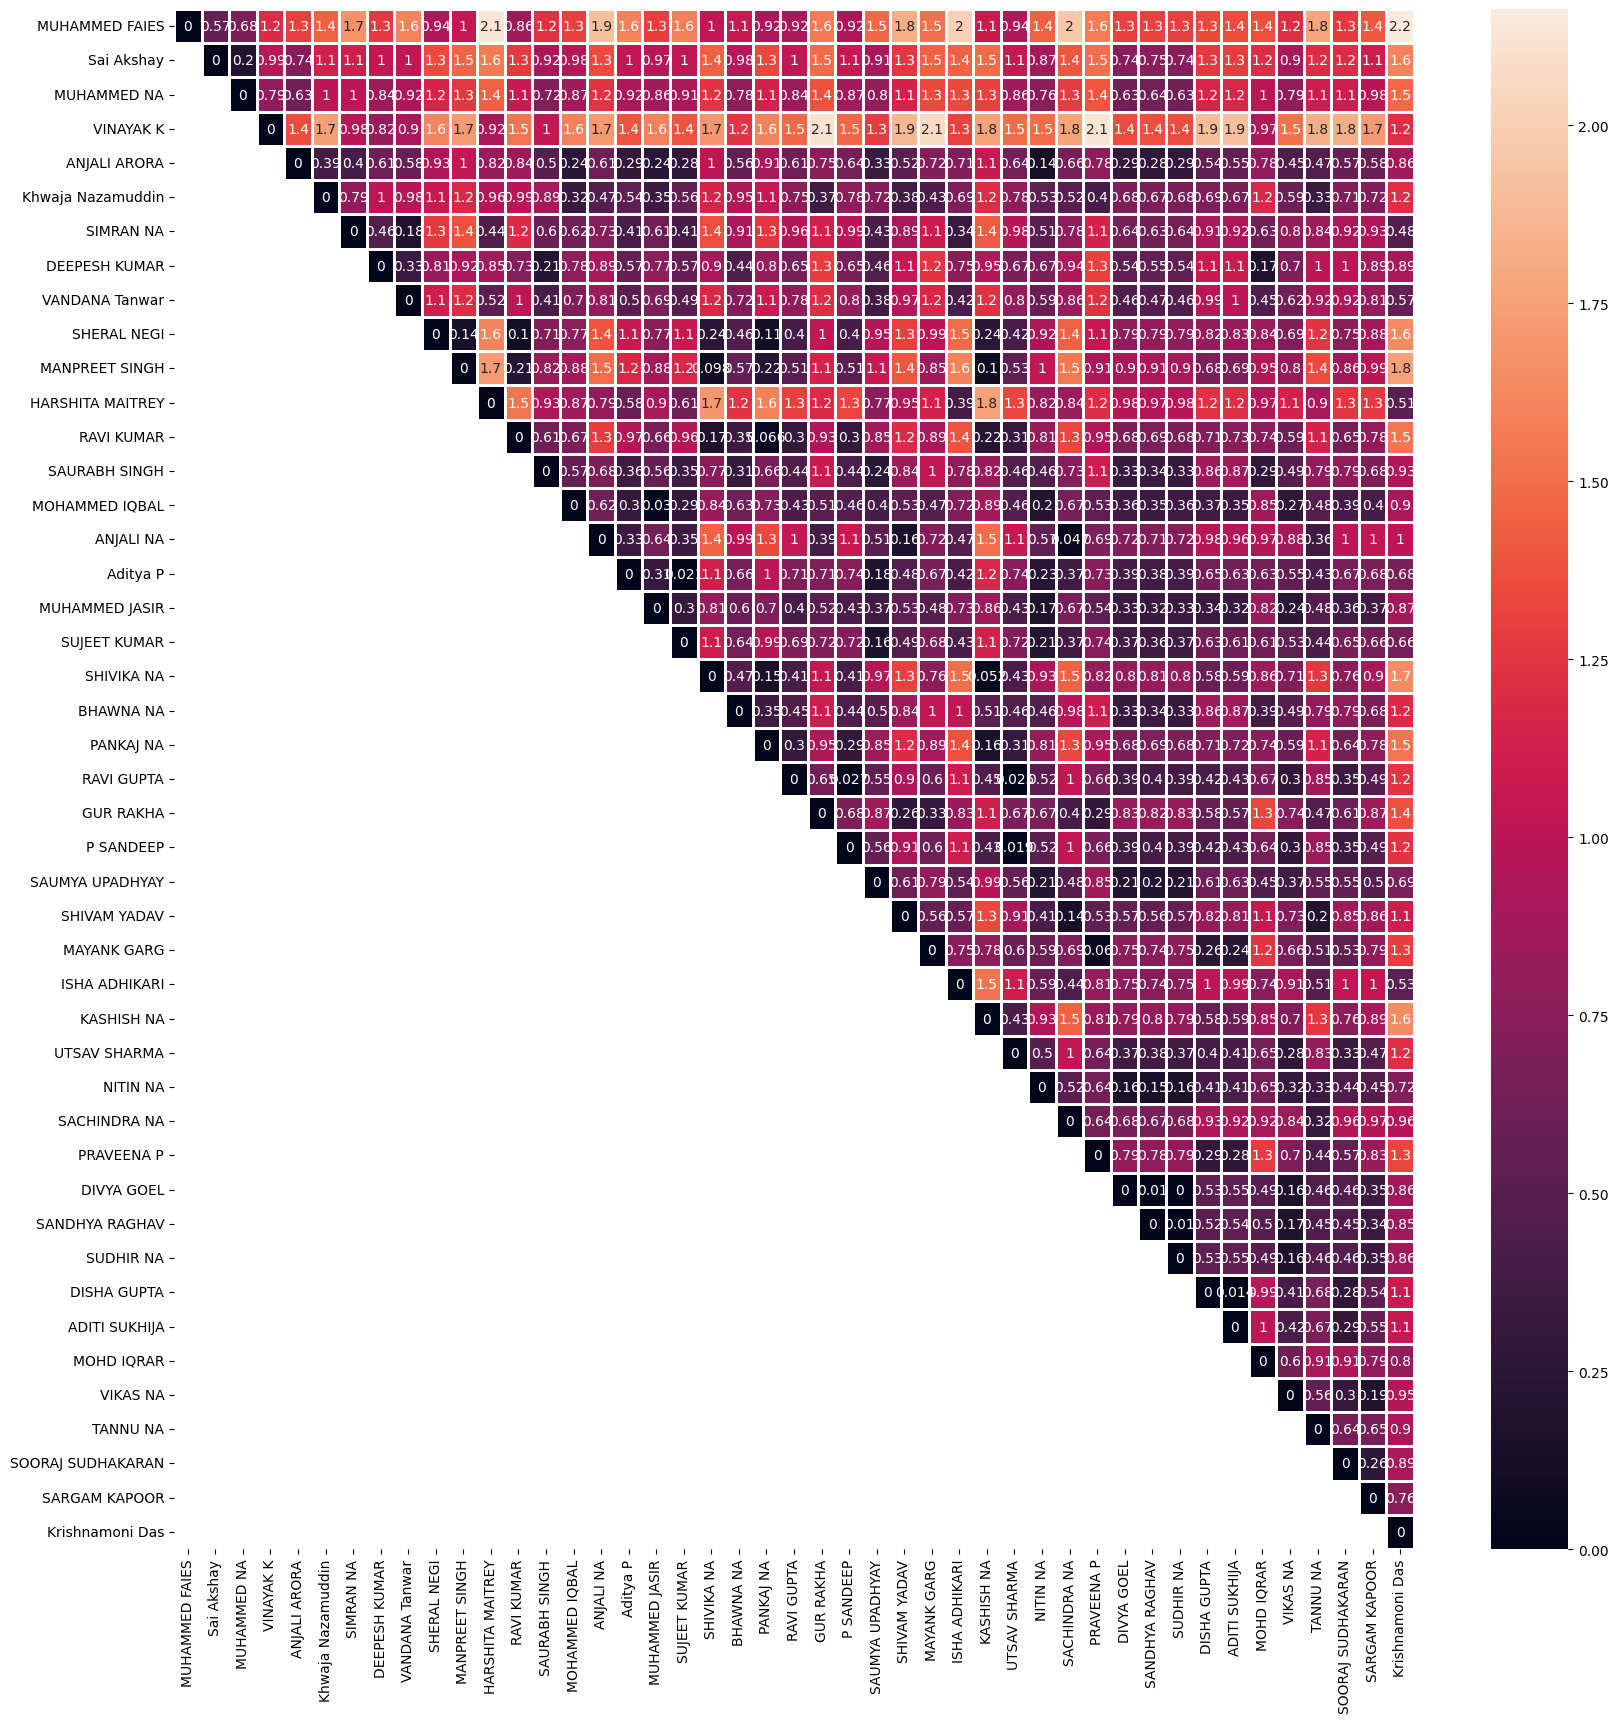

In [14]:
# making a heatmap
fig, ax = plt.subplots(figsize=(20,20))
hmap = sns.heatmap(final_df, annot=True, linewidths=1, ax=ax)

# to view the heatmap better, click on the three dots of this cell, right top hand corner and click on "view output cell in fullscreen".
hmap.figure.savefig("Correlation_Heatmap.png",
                    format='png',
                    dpi=600)

In [15]:
# move to long form
long_form = final_df.unstack()

# rename columns and turn into a dataframe
long_form.index.rename(['Student A', 'Student B'], inplace=True)
long_form = long_form.to_frame('Euclidean').reset_index()

In [16]:
final_df.iloc[14][17] #mohd iqbal and mohd jasir ('the lower the dist, the more similar their variables which imply a greater probability of them cheating')

0.029858233520175914

In [17]:
# printing only relevant values
x=long_form[
    (long_form['Euclidean'] < 0.029858233520175914)
    & (long_form['Student A'] != long_form['Student B'])]
x.sort_values(by=['Euclidean'])

,Student A,Student B,Euclidean
1654,SUDHIR NA,DIVYA GOEL,0.000000
1609,SANDHYA RAGHAV,DIVYA GOEL,0.009957
1655,SUDHIR NA,SANDHYA RAGHAV,0.009957
1747,ADITI SUKHIJA,DISHA GUPTA,0.013514
1374,UTSAV SHARMA,P SANDEEP,0.018519
826,SUJEET KUMAR,Aditya P,0.020867
1372,UTSAV SHARMA,RAVI GUPTA,0.024584
1102,P SANDEEP,RAVI GUPTA,0.027402
